In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from binance_data_loader import BinanceDataLoader
from tqdm import tqdm

In [2]:
data_loader = BinanceDataLoader(
    data_directory=r"C:\Users\USER\Documents\Binance_related\dailytickerdata2020",
    funding_rate_directory=r"C:\Users\USER\Documents\Binance_related\fundingratedata2022",
    min_records=30,
    min_volume=1e5,
    start_date="2022-01-01",
    end_date=None
)

Loading Binance data from C:\Users\USER\Documents\Binance_related\dailytickerdata2020...
Found 567 USDT trading pairs
✓ BTCUSDT loaded successfully with 1383 records, avg volume: 347,594
Loaded 530 cryptocurrencies
Filtered 35 cryptocurrencies (insufficient data/volume)
Precomputing returns matrix (FAST numpy version)...
Building returns matrix for 529 tickers over 1383 dates...
Precomputed returns matrix shape: (1383, 529)
Date range: 2022-01-01 00:00:00 to 2025-10-14 00:00:00
Loading funding rate data from C:\Users\USER\Documents\Binance_related\fundingratedata2022...
Found 567 funding rate files
Loaded funding rates for 529 symbols


In [3]:
price = data_loader.get_price_matrix()
funding_rates = data_loader.get_funding_rate_matrix()

print("=== INITIAL DATA DEBUG ===")
print("Price matrix shape:", price.shape)
print("Funding rate matrix shape:", funding_rates.shape)
print("Common symbols:", len(set(price.columns) & set(funding_rates.columns)))

# Align matrices to common symbols and dates - PRESERVE CHRONOLOGICAL ORDER
common_symbols = list(set(price.columns) & set(funding_rates.columns))

# Get intersection of dates but keep chronological order
price_dates = set(price.index)
funding_dates = set(funding_rates.index)
common_dates_set = price_dates & funding_dates

# Keep original chronological order from price data
common_dates = [date for date in price.index if date in common_dates_set]

print(f"Using {len(common_symbols)} symbols and {len(common_dates)} dates")
print(f"Date range: {common_dates[0]} to {common_dates[-1]}")

price_aligned = price.loc[common_dates, common_symbols]
funding_aligned = funding_rates.loc[common_dates, common_symbols]

print("Aligned price matrix shape:", price_aligned.shape)
print("Aligned funding rate matrix shape:", funding_aligned.shape)
print("First few dates in order:", price_aligned.index[:5])

Building funding rate matrix with 1383 dates and 529 tickers
Funding rate matrix final shape: (1383, 529)
=== INITIAL DATA DEBUG ===
Price matrix shape: (1383, 529)
Funding rate matrix shape: (1383, 529)
Common symbols: 529
Using 529 symbols and 1383 dates
Date range: 2022-01-01 00:00:00 to 2025-10-14 00:00:00
Aligned price matrix shape: (1383, 529)
Aligned funding rate matrix shape: (1383, 529)
First few dates in order: DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05'],
              dtype='datetime64[ns]', freq=None)


In [ ]:
# Funding Rate Strategy Parameters
volume_percentile = 0.1  # top 100% by volume (use all available)
funding_percentile = 0.2  # top/bottom 20% for long/short based on funding rates

# NEW: Quintile-based Strategy Parameters
QUINTILE_STRATEGY = True  # Set to True to use quintiles, False for original strategy
LONG_QUINTILE = 1  # Which quintile to long (1=lowest funding rates, 5=highest)
SHORT_QUINTILE = 5  # Which quintile to short (1=lowest funding rates, 5=highest)

def create_quintiles(funding_rates_series):
    """Create quintiles from funding rates, handling duplicates and edge cases"""
    if len(funding_rates_series) < 5:
        # Not enough data points for quintiles
        return None
        
    # Check if we have enough unique values
    unique_values = funding_rates_series.nunique()
    
    if unique_values < 2:
        # All values are the same, can't create meaningful quintiles
        return None
    elif unique_values < 5:
        # Use rank-based approach for limited unique values
        ranks = funding_rates_series.rank(method='first')
        quintiles = pd.cut(ranks, bins=min(unique_values, 5), labels=range(1, min(unique_values, 5) + 1))
        return quintiles
    else:
        # Try standard qcut first
        try:
            quintiles = pd.qcut(funding_rates_series, q=5, labels=[1,2,3,4,5], duplicates='drop')
            return quintiles
        except ValueError:
            # Fallback to percentile-based approach
            q20 = funding_rates_series.quantile(0.2)
            q40 = funding_rates_series.quantile(0.4)
            q60 = funding_rates_series.quantile(0.6)
            q80 = funding_rates_series.quantile(0.8)
            
            quintiles = pd.Series(index=funding_rates_series.index, dtype=int)
            quintiles[funding_rates_series <= q20] = 1
            quintiles[(funding_rates_series > q20) & (funding_rates_series <= q40)] = 2
            quintiles[(funding_rates_series > q40) & (funding_rates_series <= q60)] = 3
            quintiles[(funding_rates_series > q60) & (funding_rates_series <= q80)] = 4
            quintiles[funding_rates_series > q80] = 5
            
            return quintiles

def select_coins_from_quintile(funding_rates_series, quintile_labels, target_quintile, n_coins):
    """Select coins from a specific quintile deterministically"""
    quintile_coins = funding_rates_series[quintile_labels == target_quintile]
    
    if len(quintile_coins) == 0:
        return []
    
    # Deterministic selection: sort by funding rate value within quintile
    quintile_coins_sorted = quintile_coins.sort_values()
    
    # Take up to n_coins, or all available if fewer
    n_select = min(n_coins, len(quintile_coins_sorted))
    selected_coins = quintile_coins_sorted.head(n_select).index.tolist()
    
    return selected_coins

# Get volume data for universe selection
volume_data = {}
for ticker in data_loader.get_universe():
    if ticker in common_symbols:
        ticker_data = data_loader._crypto_universe[ticker]['data']
        volume_data[ticker] = ticker_data['volume'].reindex(price_aligned.index)

volume_matrix = pd.DataFrame(volume_data, index=price_aligned.index)
rolling_volume_matrix = volume_matrix.rolling(window=20, min_periods=10).mean()

equity = [1.0]

strategy_name = f"Quintile Strategy: Long Q{LONG_QUINTILE}, Short Q{SHORT_QUINTILE}" if QUINTILE_STRATEGY else "Original Contrarian Strategy"
print(f"Starting funding rate strategy backtest: {strategy_name}")
print(f"Price matrix: {price_aligned.shape}")
print(f"Funding rate matrix: {funding_aligned.shape}")

# Start from day 21 to ensure sufficient data
for i in range(21, len(price_aligned)-1):
    current_date = price_aligned.index[i]
    
    # Stop trading if equity is too low
    if equity[-1] < 0.01:  # Stop if lost 99% of capital
        equity.append(equity[-1])
        continue
    
    # Get 20-day rolling average volume for current date
    current_volumes = rolling_volume_matrix.iloc[i].dropna()
    
    # Skip if no volume data available
    if len(current_volumes) == 0:
        equity.append(equity[-1])
        continue
    
    # Select top X% by 20-day rolling volume for this day
    n_universe = max(1, int(len(current_volumes) * volume_percentile))
    top_volume_tickers = current_volumes.nlargest(n_universe).index
    
    # Get funding rates for the volume-filtered universe
    current_funding = funding_aligned.iloc[i][top_volume_tickers].dropna()
    
    # Skip if no valid funding rates in the volume universe
    if len(current_funding) == 0:
        equity.append(equity[-1])
        continue

    if QUINTILE_STRATEGY:
        # NEW: Quintile-based selection
        quintile_labels = create_quintiles(current_funding)
        
        if quintile_labels is None or len(quintile_labels.dropna()) == 0:
            equity.append(equity[-1])
            continue
        
        # Calculate coins per quintile for equal weighting
        n_coins_per_selection = max(1, int(len(current_funding) * funding_percentile))
        
        # Select coins from specified quintiles
        long_coins = select_coins_from_quintile(current_funding, quintile_labels, LONG_QUINTILE, n_coins_per_selection)
        short_coins = select_coins_from_quintile(current_funding, quintile_labels, SHORT_QUINTILE, n_coins_per_selection)
        
        # Ensure equal number of coins for long and short
        min_coins = min(len(long_coins), len(short_coins))
        if min_coins == 0:
            equity.append(equity[-1])
            continue
            
        long_coins = long_coins[:min_coins]
        short_coins = short_coins[:min_coins]
        
    else:
        # Original percentile-based selection
        k = max(1, int(len(current_funding) * funding_percentile))
        
        # Most negative funding rates (we want to go long these)
        long_coins = current_funding.nsmallest(k).index
        # Most positive funding rates (we want to go short these)  
        short_coins = current_funding.nlargest(k).index

    # Equal weighting - full exposure
    long_weights = pd.Series(0.5 / len(long_coins), index=long_coins)
    short_weights = pd.Series(0.5 / len(short_coins), index=short_coins)

    # Calculate weighted returns for the next day
    long_return = 0
    short_return = 0

    for coin in long_weights.index:
        p0 = price_aligned[coin].iat[i]
        p1 = price_aligned[coin].iat[i+1]
        if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
            coin_return = (p1 - p0) / p0
            long_return += long_weights[coin] * coin_return

    for coin in short_weights.index:
        p0 = price_aligned[coin].iat[i]
        p1 = price_aligned[coin].iat[i+1]
        if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
            coin_return = (p1 - p0) / p0
            short_return += short_weights[coin] * coin_return

    # Portfolio return: long - short - fees
    portfolio_return = long_return - short_return - 0.0005  # 5bps fees
    
    new_equity = equity[-1] * (1 + portfolio_return)
    
    # Only prevent negative equity (minimum realistic control)
    new_equity = max(new_equity, 0.0001)
    
    equity.append(new_equity)

print(f"Completed backtest with {len(equity)} data points")

In [ ]:
print(f"Equity variable type: {type(equity)}")
print(f"Equity length: {len(equity)}")
print(f"First few equity values: {equity[:5]}")
print(f"Last few equity values: {equity[-5:]}")

# Check if equity contains any non-scalar values
print(f"\n=== EQUITY STRUCTURE DEBUG ===")
for i, val in enumerate(equity[:10]):
    print(f"equity[{i}]: {val}, type: {type(val)}, shape: {getattr(val, 'shape', 'scalar')}")

# Check the date index alignment
print(f"\n=== DATE INDEX DEBUG ===")
print(f"price_aligned.index length: {len(price_aligned.index)}")
print(f"equity length: {len(equity)}")
print(f"Date index sample: {price_aligned.index[:len(equity)][:5]}")

# Force conversion to ensure scalars
equity_clean = [float(x) if np.isscalar(x) else float(x.iloc[0] if hasattr(x, 'iloc') else x[0]) for x in equity]
print(f"Cleaned equity sample: {equity_clean[:5]}")

plt.figure(figsize=(12, 8))

# Debug what matplotlib is actually plotting
dates_for_plot = price_aligned.index[:len(equity_clean)]
print(f"\n=== PLOTTING DEBUG ===")
print(f"Dates for plot length: {len(dates_for_plot)}")
print(f"Equity for plot length: {len(equity_clean)}")
print(f"Sample dates: {dates_for_plot[:3]}")
print(f"Sample equity: {equity_clean[:3]}")

# Dynamic title based on strategy type
strategy_title = f"Quintile Strategy: Long Q{LONG_QUINTILE}, Short Q{SHORT_QUINTILE}" if QUINTILE_STRATEGY else "Funding Rate Contrarian Strategy - Long Negative FR, Short Positive FR"

# Use the cleaned equity
plt.plot(dates_for_plot, equity_clean, label=strategy_title, linewidth=2)
plt.xlabel("Date")
plt.ylabel("Equity")
plt.title(strategy_title)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Performance metrics
equity_series = pd.Series(equity_clean, index=dates_for_plot)
daily_returns = equity_series.pct_change().dropna()

print(f"\n=== PERFORMANCE SUMMARY: {strategy_title} ===")
print(f"Total Return: {(equity_clean[-1] - 1) * 100:.2f}%")
if len(daily_returns) > 0:
    print(f"Annualized Return: {(equity_clean[-1] ** (365/len(daily_returns)) - 1) * 100:.2f}%")
    print(f"Volatility: {daily_returns.std() * np.sqrt(365) * 100:.2f}%")
    if daily_returns.std() != 0:
        print(f"Sharpe Ratio: {daily_returns.mean() / daily_returns.std() * np.sqrt(365):.2f}")
    print(f"Max Drawdown: {((equity_series / equity_series.cummax()) - 1).min() * 100:.2f}%")

print(f"\n=== STRATEGY CONFIGURATION ===")
print(f"Quintile Strategy Enabled: {QUINTILE_STRATEGY}")
if QUINTILE_STRATEGY:
    print(f"Long Quintile: Q{LONG_QUINTILE} (1=lowest funding rates, 5=highest)")
    print(f"Short Quintile: Q{SHORT_QUINTILE} (1=lowest funding rates, 5=highest)")
else:
    print(f"Original Strategy: Long {funding_percentile*100:.0f}% most negative, Short {funding_percentile*100:.0f}% most positive")

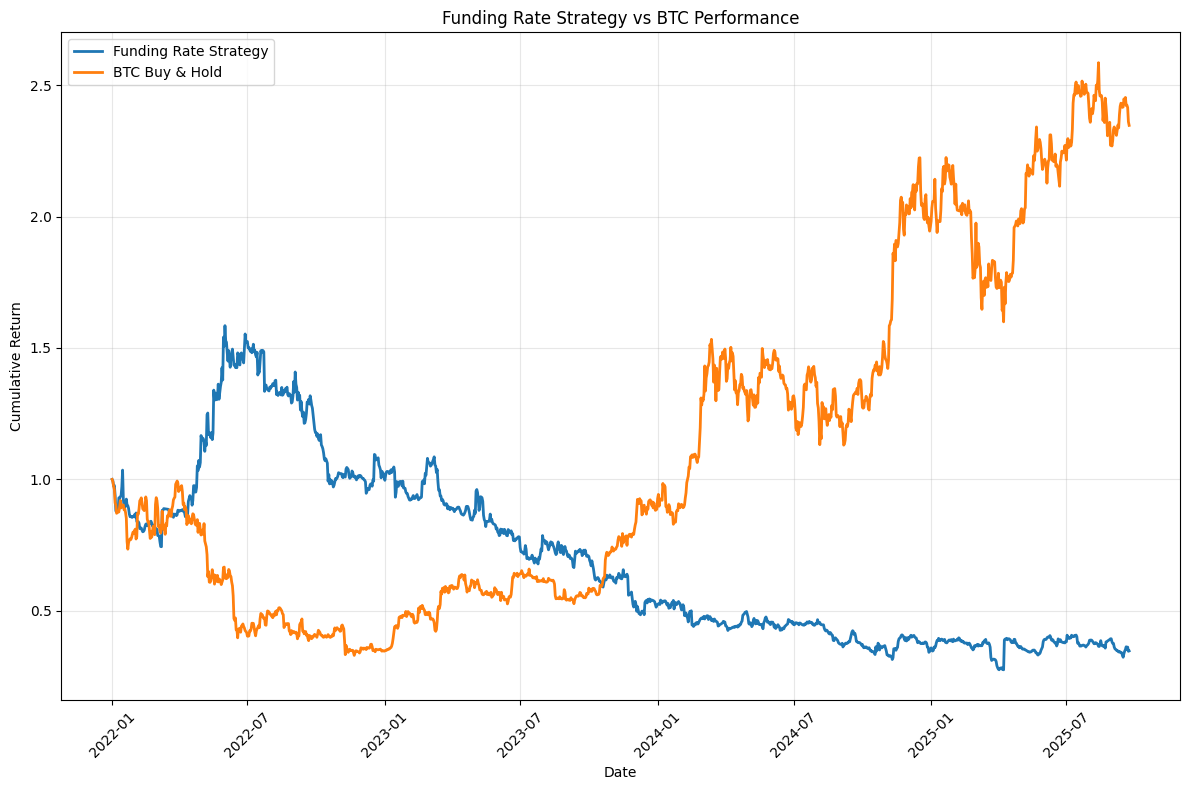

Strategy vs BTC:
Strategy Total Return: -65.23%
BTC Total Return: 134.67%
Outperformance: -85.18%


In [6]:
# Compare with BTC performance
equity_series = pd.Series(equity, index=price_aligned.index[:len(equity)])

# BTC cumulative return
if "BTCUSDT" in price_aligned.columns:
    btc_cumret = (1 + price_aligned["BTCUSDT"].pct_change().fillna(0)).cumprod()
    btc_aligned = btc_cumret.reindex(equity_series.index)
    
    plt.figure(figsize=(12, 8))
    plt.plot(equity_series.index, equity_series, label="Funding Rate Strategy", linewidth=2)
    plt.plot(btc_aligned.index, btc_aligned, label="BTC Buy & Hold", linewidth=2)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.title("Funding Rate Strategy vs BTC Performance")
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print("Strategy vs BTC:")
    print(f"Strategy Total Return: {(equity_series.iloc[-1] - 1) * 100:.2f}%")
    if not btc_aligned.empty:
        print(f"BTC Total Return: {(btc_aligned.iloc[-1] - 1) * 100:.2f}%")
        print(f"Outperformance: {((equity_series.iloc[-1] / btc_aligned.iloc[-1]) - 1) * 100:.2f}%")
else:
    print("BTC data not available for comparison")

Funding Rate Statistics:
       1000FLOKIUSDT      ONEUSDT     EGLDUSDT    FORMUSDT       BUSDT  \
count     892.000000  1383.000000  1383.000000  209.000000  145.000000   
mean        0.000016     0.000053     0.000085    0.000061    0.000204   
std         0.000799     0.000188     0.000119    0.000077    0.000214   
min        -0.020346    -0.003625    -0.000753   -0.000192    0.000050   
25%         0.000027     0.000078     0.000092    0.000050    0.000050   
50%         0.000100     0.000100     0.000100    0.000050    0.000107   
75%         0.000100     0.000100     0.000100    0.000050    0.000309   
max         0.001143     0.000743     0.000938    0.000890    0.000973   

          IOTAUSDT  BANANAS31USDT      BNXUSDT     FXSUSDT      KSMUSDT  ...  \
count  1383.000000     208.000000  1176.000000  998.000000  1383.000000  ...   
mean      0.000056       0.000024    -0.000027    0.000098     0.000009  ...   
std       0.000191       0.000165     0.001160    0.000210     0.000

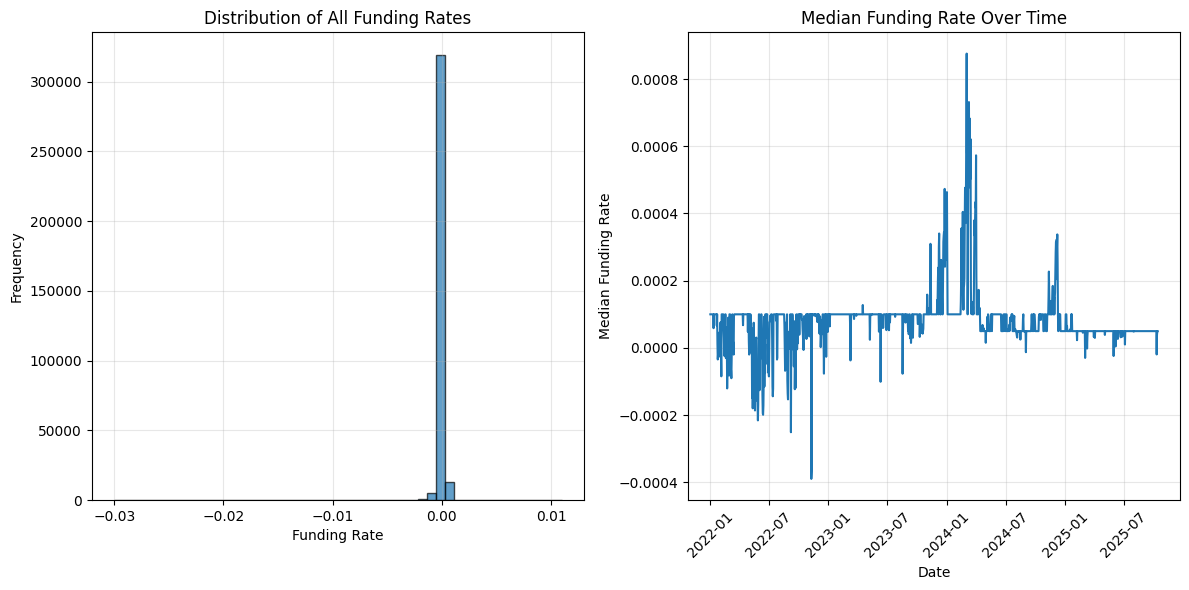

Funding Rate Range: -0.030000 to 0.010966
Median Funding Rate: 0.000075
Mean Funding Rate: 0.000028
% of Negative Funding Rates: 17.0%


In [7]:
# Funding rate analysis
print("Funding Rate Statistics:")
funding_stats = funding_aligned.describe()
print(funding_stats)

# Plot funding rate distribution
plt.figure(figsize=(12, 6))

# Subplot 1: Distribution of all funding rates
plt.subplot(1, 2, 1)
funding_flat = funding_aligned.values.flatten()
funding_flat = funding_flat[~np.isnan(funding_flat)]
plt.hist(funding_flat, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Funding Rate')
plt.ylabel('Frequency')
plt.title('Distribution of All Funding Rates')
plt.grid(True, alpha=0.3)

# Subplot 2: Time series of median funding rate
plt.subplot(1, 2, 2)
median_funding = funding_aligned.median(axis=1)
plt.plot(median_funding.index, median_funding)
plt.xlabel('Date')
plt.ylabel('Median Funding Rate')
plt.title('Median Funding Rate Over Time')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Funding Rate Range: {funding_flat.min():.6f} to {funding_flat.max():.6f}")
print(f"Median Funding Rate: {np.median(funding_flat):.6f}")
print(f"Mean Funding Rate: {np.mean(funding_flat):.6f}")
print(f"% of Negative Funding Rates: {(funding_flat < 0).mean() * 100:.1f}%")

In [ ]:
# QUINTILE COMBINATION TESTING
# Change these parameters and re-run the strategy cells above to test different combinations

print("=== QUINTILE COMBINATION TESTING ===")
print("To test different quintile combinations:")
print("1. Change LONG_QUINTILE and SHORT_QUINTILE parameters in the strategy cell above")
print("2. Re-run the strategy backtest and plotting cells")
print("")
print("Quintile Interpretation:")
print("- Q1: Lowest 20% of funding rates (most negative)")
print("- Q2: 20-40% of funding rates")  
print("- Q3: 40-60% of funding rates (middle)")
print("- Q4: 60-80% of funding rates")
print("- Q5: Highest 20% of funding rates (most positive)")
print("")
print("Example Combinations to Test:")
print("- Long Q1, Short Q5: Traditional contrarian (long negative, short positive)")
print("- Long Q5, Short Q1: Momentum strategy (long positive, short negative)")
print("- Long Q2, Short Q4: Moderate contrarian")
print("- Long Q4, Short Q2: Moderate momentum")
print("- Long Q1, Short Q2: Within negative funding rates")
print("- Long Q4, Short Q5: Within positive funding rates")
print("")

# Quick performance comparison function
def quick_quintile_test(long_q, short_q, current_equity):
    """Quick function to test a quintile combination without full backtest"""
    if len(current_equity) > 0:
        total_return = (current_equity[-1] - 1) * 100
        return total_return
    return 0

# Display current configuration
print(f"Current Configuration:")
print(f"- QUINTILE_STRATEGY: {QUINTILE_STRATEGY}")
print(f"- LONG_QUINTILE: Q{LONG_QUINTILE}")
print(f"- SHORT_QUINTILE: Q{SHORT_QUINTILE}")

if len(equity) > 1:
    current_return = (equity[-1] - 1) * 100
    print(f"- Current Strategy Return: {current_return:.2f}%")

print("")
print("To switch back to original contrarian strategy, set QUINTILE_STRATEGY = False")